In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## 1. 
###     1.1) “images/greenscreen.jpg” dosyasında yer alan renkli görüntünün 3 ayrı kanalı için histogramını hesaplayıp analiz ediniz. 

###     1.2) Görüntünün içerisinde baskın olan renk için RGB kanallarında hangi yoğunluk değerinin oluştuğunu tespit ediniz. 
###     1.3) Bu yoğunluk değerlerini RGB kanallarında istediğiniz bir renk ile güncelleyerek görüntüdeki baskın rengin değişmesini sağlayınız.

## 1.1)

Image type:  <class 'numpy.ndarray'> Image Dimensions :  (768, 1024, 3)


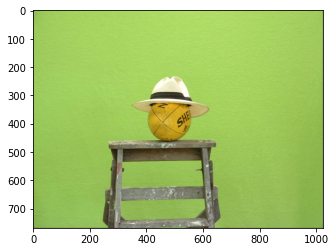

In [85]:
img_org = cv2.imread('../images/greenscreen.jpg')
if img_org is not None:
    print('Image type: ', type(img_org),
      'Image Dimensions : ', img_org.shape)
else:
    raise Exception('Image not found')

img = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB) # bgr 2 rgb
plt.imshow(img)

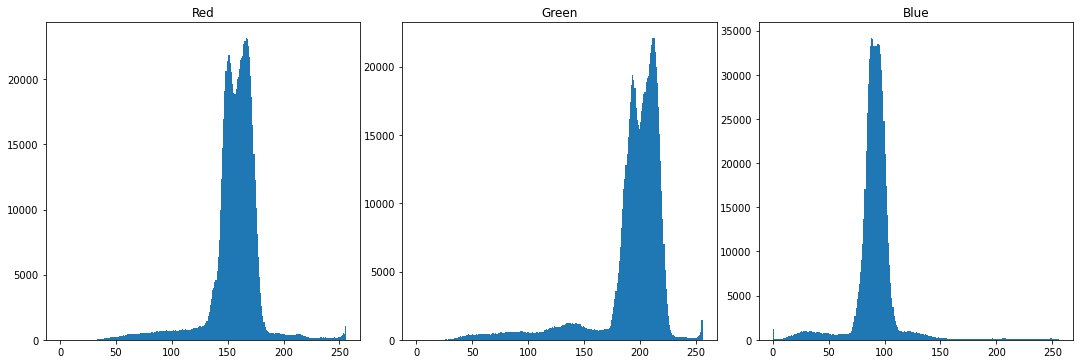

In [86]:
# plot histograms for all 3 channels
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.tight_layout()

# RGB
color_names = ["Red", "Green", "Blue",]
# BGR
# color_names = reversed(color_names)

for i, ch_name, ax in zip(range(img.shape[2]), color_names, (ax1, ax2, ax3)):
    ax.hist(img[:, :, i].ravel(), 256, [0, 256])
    ax.set_title(ch_name)

plt.show()


## 1.2)

# Method 1: Top frequency Color 

In [56]:
def unique_count_app(a):
    colors, count = np.unique(a.reshape(-1,a.shape[-1]), axis=0, return_counts=True)
    return colors[count.argmax()]
unique_count_app(img)

array([169, 214,  97], dtype=uint8)

# Method 2: Top K frequency colors

palette_percenteges: {'[169.0975312088701, 211.21570082026176, 99.41214320849784]': 0.48, '[93.99881333807997, 90.08162256240809, 59.321209604049784]': 0.06, '[150.5988492808005, 186.70034882912924, 86.10774511847616]': 0.46}


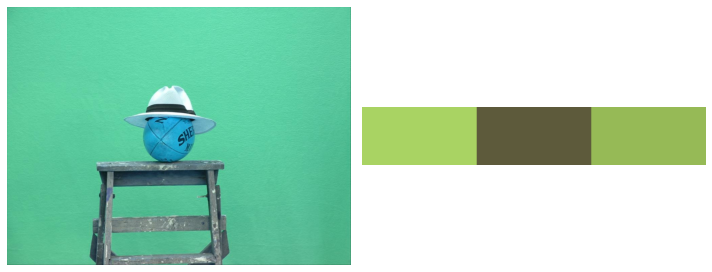

In [83]:
from sklearn.cluster import KMeans

def palette(clusters):
    width=300
    palette = np.zeros((50, width, 3), np.uint8)
    steps = width/clusters.cluster_centers_.shape[0]
    for idx, centers in enumerate(clusters.cluster_centers_): 
        palette[:, int(idx*steps):(int((idx+1)*steps)), :] = centers
    return palette


from collections import Counter
def palette_perc(k_cluster):
    width = 300
    palette = np.zeros((50, width, 3), np.uint8)
    
    n_pixels = len(k_cluster.labels_)
    counter = Counter(k_cluster.labels_) # count how many pixels per cluster
    perc = {}
    for i in counter:
        perc[i] = np.round(counter[i]/n_pixels, 2)
    perc = dict(sorted(perc.items()))
    
    # For logging purposes
    #print(perc)
    #print(k_cluster.cluster_centers_)
    palette_percenteges = {k:v for k,v in zip([str(color.tolist()) for color in k_cluster.cluster_centers_], perc.values()) }
    print(f"palette_percenteges: {palette_percenteges}")
    
    step = 0
    for idx, centers in enumerate(k_cluster.cluster_centers_): 
        palette[:, step:int(step + perc[idx]*width+1), :] = centers
        step += int(perc[idx]*width+1)
        
    return palette


def show_img_compar(img_1, img_2):
    f, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))
    ax[1].imshow(img_2)
    ax[0].axis("off")  # hide the axis
    ax[1].axis("off")
    f.tight_layout()
    #f.suptitle(title, fontsize=32)
    plt.show()


clt = KMeans(n_clusters=3)
clt_1 = clt.fit(img.reshape(-1, 3))

#color_palette = palette_perc(clt_1)
#color_palette = palette(clt_1)
show_img_compar(img, color_palette)

## Chroma keying
### https://medium.com/fnplus/blue-or-green-screen-effect-with-open-cv-chroma-keying-94d4a6ab2743

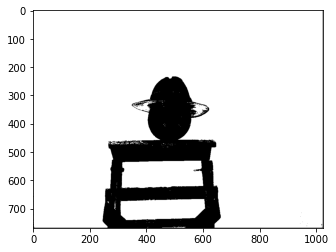

In [84]:
## Method 1: RGB filtering
img = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB) # bgr 2 rgb

lower_th = np.array([0, 170, 0])     # [R value, G value, B value]
upper_th = np.array([200, 255, 150]) 

mask = cv2.inRange(img_copy, lower_th, upper_th)

# Method 2: HSV filtering
#hsv = cv2.cvtColor(img_org, cv2.COLOR_BGR2HSV)
## mask of green (36,25,25) ~ (86, 255,255)
#mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
#mask = cv2.inRange(hsv, (36, 25, 25), (70, 255,255))

plt.imshow(mask, cmap='gray')

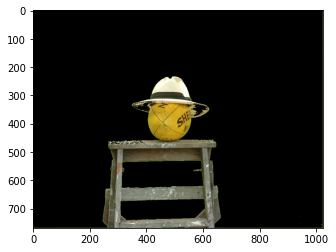

In [40]:

## slice the green
imask = mask>0
green = np.zeros_like(img, np.uint8)
green[imask] = img[imask]
plt.imshow(green)

masked_image = np.copy(img)
masked_image[mask != 0] = [0, 0, 0]
plt.imshow(masked_image)

#background_image = cv2.imread('images/treeBackground.jpg')
#background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)

background_image = np.zeros_like(img)
background_image[:] = (255, 255, 255)
crop_background = background_image[0:img.shape[0], 0:img.shape[1]]

crop_background[mask == 0] = [0, 0, 0]

plt.imshow(crop_background)

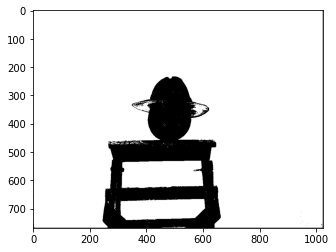

2. 
    * “images/png/printedtext.png” görüntüsündeki kararmanın giderilmesi için herhangi birgörüntü iyileştirme tekniği (lineer dönüşüm, gamma veya log dönüşümü, yerel veya genel
histogram eşitleme) deneyip ikinci bir görüntü elde ediniz. 
    * İlk ve ikinci görüntünün histogramlarını bastırıp analiz ediniz. 
    * İyileştirilmiş görüntüde uygun bir eşik değeri belirleyip görüntüyü bölütleyiniz. 
    * Uyguladığınız iyileştirme yaklaşımının harfleri arka plandan ayırmada ne derece etkin olduğunu değerlendiriniz.

3. 
   * “images/png/toysflash.png” görüntüsünü gri düzey bir görüntüye çevirip üzerine Gauss
gürültüsü ekleyiniz. 
   * Eklediğiniz gürültüyü temizlemek için standart sağması 5 olan bir
   * Gauss filtre oluşturunuz ve alçak geçirgen filtreleme işlemini gerçekleştiriniz. 
   * Görüntünün orijinal, gürültü eklenmiş ve filtrelenmiş durumları için 3-B grafiğini çizdiriniz. 
   * Ardından filtrelenmiş görüntünün x ve y eksenlerindeki kısmi türevlerini hesaplayıp eğim genliği ve
eğim açısı görüntülerini oluşturunuz. 
   * Açı görüntüsü içerisinden açısı 𝜋, 𝜋/2, 𝜋/3 ve 2𝜋/3 olan açıları çekip ayrı görüntüler oluşturunuz ve ekrana bastırınız. 
   * Açı görüntülerinin genlik görüntüsüne bağlı olarak nasıl oluştuğunu değerlendiriniz.

4. 
    * “images/sharks.png” görüntüsünü açıp ikili bir görüntü elde ediniz. 
    * Görüntü üzerinde daire şeklinde bir yapısal eleman kullanarak açma (opening) işlemi gerçekleştiriniz. 
    * Ardından görüntü üzerinde bağlı bileşen etiketleme algoritmasını çalıştırıp her bir etiketin farklı bir renkte gösterildiği etiket görüntüsünü oluşturunuz.
    * Algoritma neticesinde görüntüde kaç adet köpek balığı sayıldığını belirtiniz.